In [87]:
import torch
import torch.nn as nn
import torchvision


def attention_calculation(querys, keys, values, masked=False):
    D = querys.shape[-1]
    T = querys.shape[-2]
    # V = values.shape[-2]
                              # query <B,L,D> ,  key <B,J,D>
    similarity = torch.einsum("bld, bjd -> blj", querys, keys)*(D**-0.5)
    
    if masked:
        masked = torch.tril(torch.ones((T,T))).to(querys.device)
        similarity = similarity.masked_fill(masked == 0, float('-inf'))

    # attention = F.softmax(similarity, dim=-1)
    weighted_values = torch.einsum("blj, bjd -> bld", similarity, values)
    return weighted_values

class head(nn.Module):
    def __init__(self, embed_size, head_size):
        super().__init__()
        self.keys = nn.Linear(embed_size, head_size, bias=False)
        self.queries = nn.Linear(embed_size, head_size, bias=False)
        self.values = nn.Linear(embed_size, head_size, bias=False)
        
    def forward(self, x):
        B,T,C = x.shape # (B,window_size,embed_Size)
        k = self.keys(x) # (B,window_size,Head_size)
        q = self.queries(x)# (B,window_size,Head_size)
        v = self.values(x)# (B,window_size,Head_size)
        return attention_calculation(q,k,v)

class mulit_head_attention(nn.Module):
    def __init__(self,num_heads, head_size, embed_size):
        super().__init__()
        self.heads = nn.ModuleList([head(embed_size, head_size) for _ in range(num_heads)])
        self.fc = nn.Linear(num_heads*head_size, embed_size)
        
    def forward(self, x):
        return self.fc(torch.cat([h(x) for h in self.heads], dim=-1))

class block(nn.Module):
    def __init__(self,num_heads, head_size, embed_size):
        super().__init__()
#         head_size = embed_size // num_heads
        self.multi_head = mulit_head_attention(num_heads ,head_size, embed_size)
        self.ln1 = nn.LayerNorm(embed_size)
        self.ln2 = nn.LayerNorm(embed_size)
        self.ffnn = self.ffc = nn.Sequential(
            nn.Linear(embed_size, embed_size),
            nn.GELU(),
            nn.Linear(embed_size, embed_size)
        )

    def forward(self, x): 
        x = x + self.multi_head(x)
        x = x + self.ffnn(self.ln1(x))
        return self.ln2(x)
    
class VisionTransformer_cs(nn.Module):
    def __init__(self, num_classes, img_size, patch_size, embedding_dim, num_heads, head_size, num_layers):
        super(VisionTransformer_cs, self).__init__()
        self.patch_embedding = nn.Conv2d(3, embedding_dim, kernel_size=patch_size, stride=patch_size)
        self.position_embedding = nn.Embedding((img_size//patch_size)**2, embedding_dim)
        self.cls_tkn = nn.Parameter(torch.randn(embedding_dim))
        self.transformer_layers = nn.ModuleList([
            block(num_heads, head_size, embedding_dim) for _ in range(num_layers)
        ])
        self.fc = nn.Linear(embedding_dim, num_classes)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        batch_size = x.size(0)
        h = self.patch_embedding(x)
        h = h.flatten(2).transpose(1, 2)
        T = h.shape[-2]
        h += self.position_embedding(torch.arange(T,device=x.device))
        h = torch.cat([self.cls_tkn.unsqueeze(0).unsqueeze(0).repeat((batch_size, 1, 1)), h], dim=-2)
        for layer in self.transformer_layers:
            h = layer(h)
        h = h[:,0]
        h = self.softmax(self.fc(h))
        return h

In [75]:


class MultiheadAttentionEinsum(nn.Module):
    def __init__(self, embedding_dim, num_heads):
        super(MultiheadAttentionEinsum, self).__init__()
        self.num_heads = num_heads
        self.head_dim = embedding_dim // num_heads

        self.q_linear = nn.Linear(embedding_dim, embedding_dim)
        self.k_linear = nn.Linear(embedding_dim, embedding_dim)
        self.v_linear = nn.Linear(embedding_dim, embedding_dim)
        self.fc_out = nn.Linear(embedding_dim, embedding_dim)

    def forward(self, query, key, value):
        B,T,E = query.shape # (batch_size, seq_len, embedding_dim)
        q = self.q_linear(query).view((B,T,self.num_heads, self.head_dim))# (batch_size, seq_len, num_haeds, head_dim)
        k = self.k_linear(key).view((B,T,self.num_heads, self.head_dim))# (batch_size, seq_len, num_haeds, head_dim)
        v = self.v_linear(value).view((B,T,self.num_heads, self.head_dim))# (batch_size, seq_len, num_haeds, head_dim)
        
        similarities = torch.einsum("btnh,blnh ->btnl ", q, k)/((self.head_dim*self.num_heads)**(1/2)) # (batch_size, seq_len, num_haeds, seq_len_keys)
        similarities = nn.functional.softmax(similarities, dim=-1)
        attended_values = torch.einsum("btnl,blnh->btnh", similarities, v).reshape((B,T,self.num_heads*self.head_dim))
        # Linear projection
        out = self.fc_out(attended_values)
        return out

In [76]:
import torch
import torch.nn as nn

class TransformerEncoderLayer(nn.Module):
    def __init__(self, embedding_dim, num_heads):
        super(TransformerEncoderLayer, self).__init__()
        self.multihead_attention = MultiheadAttentionEinsum(embedding_dim, num_heads)
        self.feed_forward = nn.Sequential(
            nn.Linear(embedding_dim, 2048),
            nn.ReLU(),
            nn.Linear(2048, embedding_dim)
        )
        self.layer_norm1 = nn.LayerNorm(embedding_dim)
        self.layer_norm2 = nn.LayerNorm(embedding_dim)

    def forward(self, x): 
        attn_output = self.multihead_attention(x, x, x) + x # self-attention
        h = self.layer_norm1(attn_output)
        
        h = self.feed_forward(h) + h
        h = self.layer_norm2(h)
        return x


In [77]:
class VisionTransformer(nn.Module):
    def __init__(self, num_classes, img_size, patch_size, embedding_dim, num_heads, num_layers):
        super(VisionTransformer, self).__init__()
        self.patch_embedding = nn.Conv2d(3, embedding_dim, kernel_size=patch_size, stride=patch_size)
        self.position_embedding = nn.Embedding((img_size//patch_size)**2, embedding_dim)
        self.cls_tkn = nn.Parameter(torch.randn(embedding_dim))
        self.transformer_layers = nn.ModuleList([
            TransformerEncoderLayer(embedding_dim, num_heads) for _ in range(num_layers)
        ])
        self.fc = nn.Linear(embedding_dim, num_classes)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        batch_size = x.size(0)
        h = self.patch_embedding(x)
        h = h.flatten(2).transpose(1, 2)
        T = h.shape[-2]
        h += self.position_embedding(torch.arange(T,device=x.device))
        h = torch.cat([self.cls_tkn.unsqueeze(0).unsqueeze(0).repeat((batch_size, 1, 1)), h], dim=-2)
        for layer in self.transformer_layers:
            h = layer(h)
        h = h.mean(dim=1)
        h = self.softmax(self.fc(h))
        return h

In [81]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
num_epochs = 20
batch_size = 64
learning_rate = 5e-3
num_classes = 10
patch_size = 16
embedding_dim = 128
num_heads = 8
head_size= 32
num_layers = 3
img_size = 224

# CIFAR-10 dataset preprocessing
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

# Data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [82]:
from tqdm.notebook import tqdm 

# Initialize the model
# model = VisionTransformer(num_classes, img_size, patch_size, embedding_dim, num_heads, num_layers).to(device)
model = VisionTransformer_cs(num_classes, img_size, patch_size, embedding_dim, num_heads, head_size, num_layers).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
def Training(model, criterion, optimizer, train_loader, num_epochs, device):
    total_loss = []
    for epoch in range(num_epochs):
        epoch_loss = 0
        pbar = tqdm(train_loader)
        for img, label in pbar:
            img = img.to(device)
            label = label.to(device)

            p_label = model(img)
            loss = criterion(p_label, label)

            optimizer.zero_grad() 
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            pbar.set_description(f"Epoch [{epoch + 1}] Train Loss : [{loss.item()}]")
        epoch_loss = epoch_loss/len(train_loader)
        total_loss.append(epoch_loss)
    return model, total_loss

model, total_loss = Training(model, criterion, optimizer, train_loader, num_epochs, device)

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

As it is being shown after implementing this mutltihead attention like this we are able to see the reduction in loss of the model and these parameters I used is great for now but it could be better with much higher computational power and because I dont have access to such power I wont train it thu


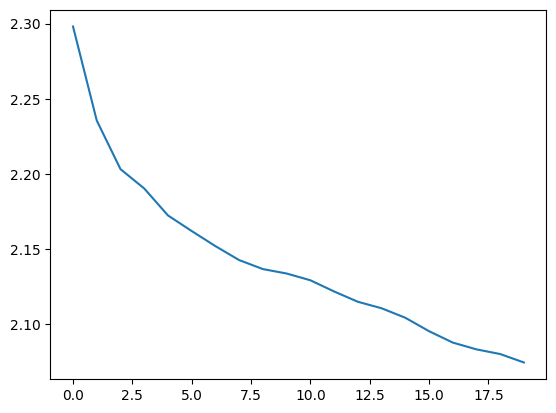

In [83]:
import matplotlib.pyplot as plt
plt.plot(total_loss)   

In [94]:
@torch.no_grad()
def Evaluate(model, test_loader, device):
    #Testing Phase
    model.eval()
    correct = 0
    total = 0
    pbar = tqdm(train_loader)
    for img, label in pbar:
        img = img.to(device)
        label = label.to(device)
        p_label = model(img)
        indeces = torch.argmax(p_label, dim=-1)
        correct += (label == indeces).sum().to("cpu")
        total += label.shape[0]
    accuracy = 100 * correct / total
    print(f'Test Accuracy of the model on the {total} test images: {accuracy:.2f}%')
    return accuracy
Evaluate(model, test_loader, device)

  0%|          | 0/782 [00:00<?, ?it/s]

Test Accuracy of the model on the 50000 test images: 39.66%


tensor(39.6600)

In [95]:
def load_resnet18_for_finetuning(num_classes, freeze_all=True):
    model = torchvision.models.resnet18(pretrained=True)
    if freeze_all:
        for param in model.parameters():
            param.requires_grad = False
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 128),
        nn.ReLU(),
        nn.Linear(128, num_classes),
        nn.Softmax(dim=-1)  # Add softmax activation function
    )
    return model

In [96]:

num_epochs = 10
learning_rate = 1e-6

As we can see the result of the VIT with small sample size is much better that pretrained resnet18 

In [97]:
resnet = load_resnet18_for_finetuning(num_classes).to(device)
resnet, total_loss = Training(resnet, criterion, optimizer, train_loader, num_epochs, device)
Evaluate(resnet, test_loader, device)

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Test Accuracy of the model on the 50000 test images: 12.15%


tensor(12.1520)